<a href="https://colab.research.google.com/github/Guilherme-dL/EconoFinPyR/blob/main/Markowitz%20-%20Otimiza%C3%A7%C3%A3o%20de%20Portfolio%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Otimização de uma Carteira de Investimentos - Aplicação da Teoria Moderna do Portfólio

In [5]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn as  sns
import datetime as dt

In [6]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,5)
sns.set()

### Período dos Dados:

In [3]:
Start = '2016-01-01'
End = '2020-01-01'

### Ações Consideradas:

*   WEGE
*   Renner
*   YDUQS
*   Rumo
*   Taesa

In [4]:
tickers = ['WEGE3.SA','LREN3.SA','YDUQ3.SA','RAIL3.SA','TAEE11.SA']

In [5]:
Carteira = web.DataReader(tickers,'yahoo',Start,End)['Adj Close']

In [6]:
Ibov = web.DataReader('^BVSP','yahoo',Start,End)['Adj Close']

In [7]:
Carteira.columns= ['WEGE','Renner','YDUQS','Rumo','Taesa']

In [8]:
Carteira.describe()

,WEGE,Renner,YDUQS,Rumo,Taesa
count,995.000000,995.000000,995.000000,995.000000,995.000000
mean,16.092622,28.905600,22.022521,12.541628,16.864166
std,4.806240,10.678625,8.652217,6.223261,4.181958
min,9.125544,12.146028,8.335582,1.500000,8.963888
25%,12.244871,20.049263,14.199422,7.110000,14.629103
50%,16.435781,26.929825,22.480381,12.860000,15.565048
75%,18.256811,35.530895,28.424644,17.115001,19.715525
max,35.057728,55.829906,48.780464,26.870001,27.920645


### Visualizando as Cotações Diárias:

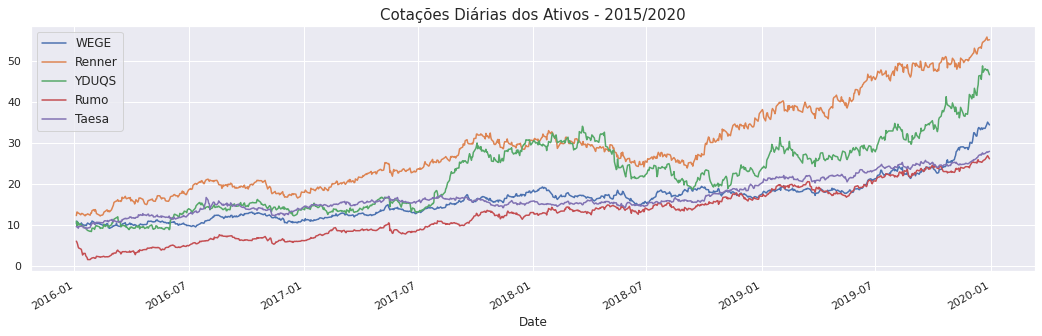

In [9]:
Carteira.plot()
plt.title('Cotações Diárias dos Ativos - 2015/2020',fontsize=15)
plt.legend(fontsize=12)
plt.show()

### Normalizando as Cotações Diárias:

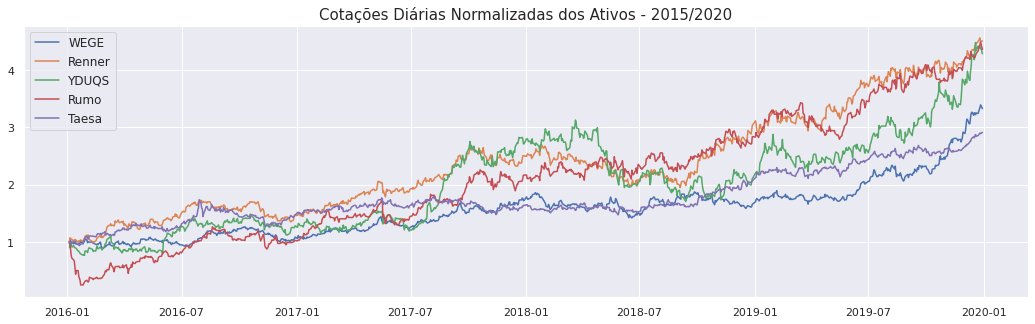

In [10]:
plt.plot(Carteira/Carteira.iloc[0])
plt.title('Cotações Diárias Normalizadas dos Ativos - 2015/2020',fontsize=15)
plt.legend(Carteira.columns,fontsize=12)
plt.show()

### Variação Percentual Diária das Cotações:

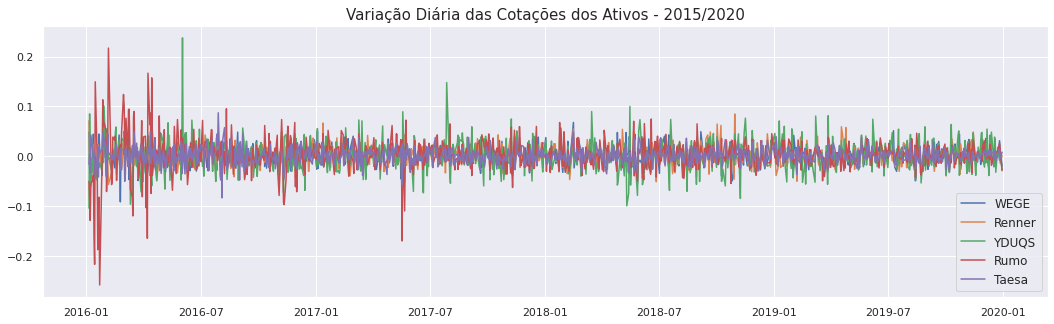

In [11]:
plt.plot(Carteira.pct_change())
plt.title('Variação Diária das Cotações dos Ativos - 2015/2020',fontsize=15)
plt.legend(Carteira.columns,fontsize=12)
plt.show()

### Comparação Ibovespa x Carteira:

In [12]:
Cart_Saldo = Carteira.sum(axis=1)/Carteira.iloc[0].sum()
Ibov_Norm = Ibov/Ibov.iloc[0]

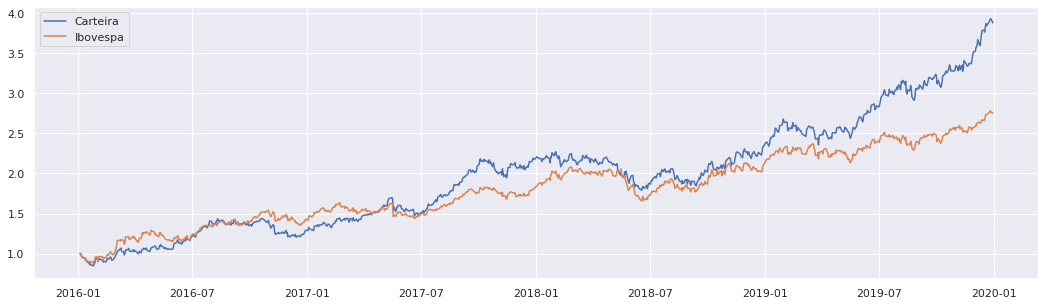

In [13]:
plt.plot(Carteira.sum(axis=1)/Carteira.iloc[0].sum(),label='Carteira')
plt.plot(Ibov/Ibov.iloc[0],label='Ibovespa')
plt.legend()
plt.show()

In [14]:
print('Correlação entre Saldo da Carteira e Ibovespa')
print(Cart_Saldo.corr(Ibov_Norm))

Correlação entre Saldo da Carteira e Ibovespa
0.9742056364347791


### Otimização:

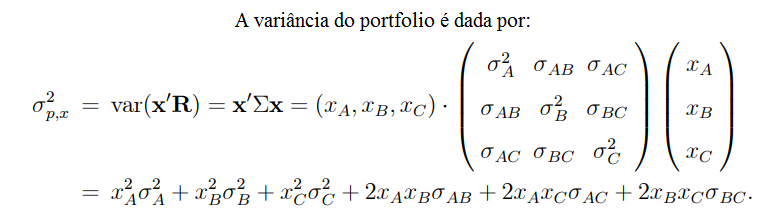

Matriz de covariância dos retornos:

In [15]:
Carteira.pct_change().cov()

,WEGE,Renner,YDUQS,Rumo,Taesa
WEGE,0.000319,0.000148,0.000133,0.000132,0.000071
Renner,0.000148,0.000383,0.000229,0.000195,0.000100
YDUQS,0.000133,0.000229,0.000875,0.000250,0.000108
Rumo,0.000132,0.000195,0.000250,0.001087,0.000118
Taesa,0.000071,0.000100,0.000108,0.000118,0.000250


Matriz de correlação dos retornos:

In [16]:
Carteira.pct_change().corr()

,WEGE,Renner,YDUQS,Rumo,Taesa
WEGE,1.000000,0.423068,0.251012,0.224113,0.251830
Renner,0.423068,1.000000,0.394721,0.301700,0.323311
YDUQS,0.251012,0.394721,1.000000,0.256575,0.231340
Rumo,0.224113,0.301700,0.256575,1.000000,0.226944
Taesa,0.251830,0.323311,0.231340,0.226944,1.000000


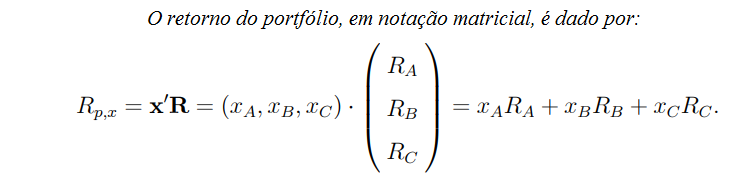

Retorno médio anualizado dos ativos, variância da carteira, covariância e correlação da carteira.

In [17]:
r = np.mean(Carteira.pct_change(),axis=0)*252

# Variância anualizada dos retornos:
Port_Var = Carteira.pct_change().var(axis=0)*252

# Matriz de covariância dos retornos:
Port_Cov = Carteira.pct_change().cov()

# Matriz de correlação dos retornos:
Port_Corr = Carteira.pct_change().corr()

Retorno médio de cada ativo:

In [18]:
print('Retorno Médio Anualizado:')
print(r)

Retorno Médio Anualizado:
WEGE      0.344916
Renner    0.429985
YDUQS     0.478142
Rumo      0.513398
Taesa     0.302639
dtype: float64


Retorno e volatilidade de cada ativo é ponderado por seu peso. Cálculo simplificado do Índice de Sharpe de cada ativo.

In [19]:
# Definindo algumas funções
# r é o retorno do ativo, w é o peso do ativo no portfólio, covar é a matriz de covariância

# Taxa de retorno
def ret(r,w):
    return r.dot(w)

# Volatilidade
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
    
# Sharpe
def sharpe (ret,vol):
    return ret/vol

### Simulação de Pesos:

In [20]:
num_ports = 20000 # Número de Simulações
all_weights = np.zeros((num_ports, len(Carteira.columns))) # Vetor de pesos simulados
ret_arr = np.zeros(num_ports) # Vetor de retornos resultantes
vol_arr = np.zeros(num_ports) # Vetor de desvios padrão resultantes
sharpe_arr = np.zeros(num_ports) # Vetor de Índices de Sharpe resultantes

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(Carteira.columns)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (r* weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(Port_Cov, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

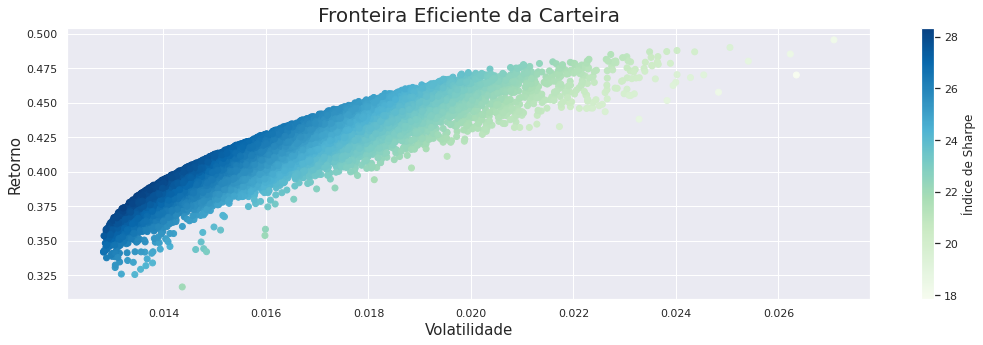

In [21]:
plt.figure()
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='GnBu')
plt.colorbar(label='Índice de Sharpe')
plt.xlabel('Volatilidade',fontsize=15)
plt.ylabel('Retorno',fontsize=15)
plt.title('Fronteira Eficiente da Carteira',fontsize=20)
plt.show()

### Otimização - Carteira de Mínima Variância e Máximo Sharpe:

In [22]:
bounds = sco.Bounds(0, 1) # Pesos entre 0 e 1

# A segunda restrição é a soma dos pesos.
constraints = sco.LinearConstraint(np.ones((Carteira.pct_change().shape[1],), dtype=int),1,1)

# Calculando o portfolio com o menor risco (minimização condicional).
weights = np.ones(Carteira.pct_change().shape[1])
x0 = weights/np.sum(weights)
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,Port_Cov)))
res = sco.minimize(fun1,x0,method='SLSQP',constraints = constraints,bounds = bounds)

#Obtendo os pesos de cada ativo no portfolio de menor risco.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
print(w_min)
print('Retorno: % .4f'% (ret(r,w_min)), 'Risco: % .4f'% vol(w_min,Port_Cov))

[0.31 0.15 0.03 0.03 0.48]
Retorno:  0.3462 Risco:  0.0128


In [23]:
#Definindo 1/Sharpe
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,Port_Cov)))/r.dot(w)
res_sharpe = sco.minimize(fun2,x0,method='SLSQP',constraints = constraints,bounds = bounds)

#Obtendo os pesos de cada ativo no portfolio com o maior Índice de Sharpe.
w_sharpe = res_sharpe.x
print(w_sharpe)
print('Retorno: % .4f'% (ret(r,w_sharpe)), 'Risco: % .4f'% vol(w_sharpe,Port_Cov))

[0.25 0.25 0.09 0.09 0.32]
Retorno:  0.3805 Risco:  0.0134


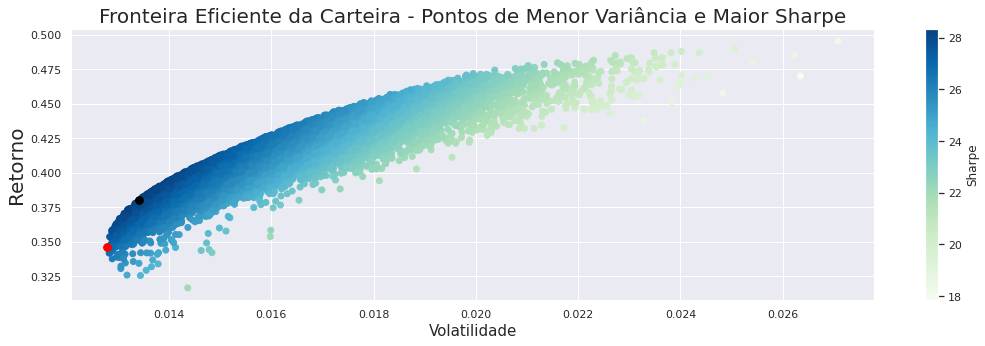

In [24]:
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='GnBu')
plt.colorbar(label='Sharpe')
plt.xlabel('Volatilidade',fontsize=15)
plt.ylabel('Retorno',fontsize=20)
plt.scatter(vol(w_sharpe,Port_Cov), ret(r,w_sharpe),c='black',s=60) # Carteira de maior Sharpe em vermelho
plt.scatter(vol(w_min,Port_Cov),ret(r,w_min),c='red',s=60) # Carteira de menor variância em azul.
plt.title('Fronteira Eficiente da Carteira - Pontos de Menor Variância e Maior Sharpe',fontsize=20)
plt.show()

### Otimização - Fronteira Eficiente:

In [25]:
w2 = w_min
num_ports2 = 100
gap = (np.amax(r) - ret(r,w_min))/num_ports2


all_weights2 = np.zeros((num_ports2, len(Carteira.columns)))
all_weights2[0],all_weights2[1]=w_min,w_sharpe
ret_arr2 = np.zeros(num_ports2)
ret_arr2[0],ret_arr2[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr2 = np.zeros(num_ports2)
vol_arr2[0],vol_arr2[1]=vol(w_min,Port_Cov),vol(w_sharpe,Port_Cov)

for i in range(num_ports2):
    port_ret2 = ret(r,w2) + i*gap
    double_constraint = sco.LinearConstraint([np.ones(Carteira.pct_change().shape[1]),r],[1,port_ret2],[1,port_ret2])
    
    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w2: np.sqrt(np.dot(w2,np.dot(w2,Port_Cov)))
    a = sco.minimize(fun,x0,method='SLSQP',constraints = double_constraint,bounds = bounds)
    
    all_weights2[i,:]=a.x
    ret_arr2[i]=port_ret2
    vol_arr2[i]=vol(a.x,Port_Cov)
    
sharpe_arr2 = ret_arr2/vol_arr2  

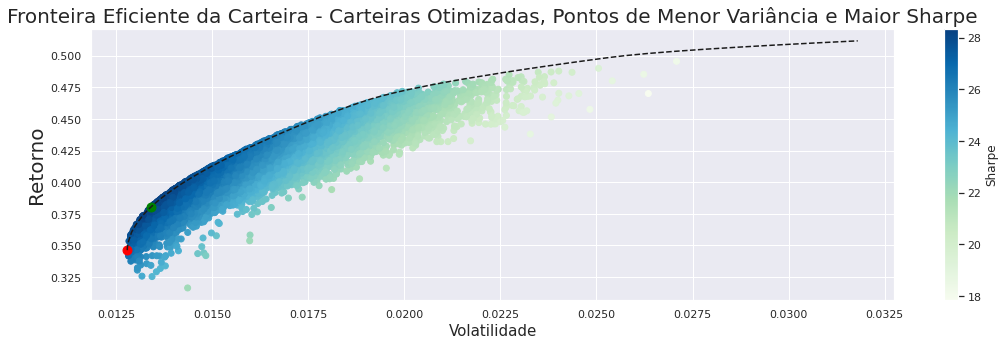

In [26]:
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='GnBu')
plt.colorbar(label='Sharpe')
plt.xlabel('Volatilidade',fontsize=15)
plt.ylabel('Retorno',fontsize=20)
plt.scatter(vol(w_sharpe,Port_Cov), ret(r,w_sharpe),c='green', s=80) # Carteira de maior Sharpe em vermelho
plt.scatter(vol(w_min,Port_Cov),ret(r,w_min),c='red',s=80) # Carteira de menor variância em azul.
plt.title('Fronteira Eficiente da Carteira - Carteiras Otimizadas, Pontos de Menor Variância e Maior Sharpe',fontsize=20)
plt.plot(vol_arr2, ret_arr2,'--k') # Fronteira Eficiente
plt.show()

## Backtest das Carteiras Otimizadas:

In [33]:
Carteira_Retornos = Carteira.pct_change()

In [34]:
Carteira_Alvos = pd.DataFrame()
for ticker in Carteira_Retornos.columns:
  Carteira_Alvos[ticker +' Alvo'] = Carteira_Retornos[ticker].shift(-1)

In [35]:
Carteira_Alvos['MaiorSharpe'] = (w_sharpe*Carteira_Alvos).sum(axis=1)

In [54]:
Carteira_Alvos['MínimaVariância'] = (w_min*Carteira_Alvos.iloc[:,:5]).sum(axis=1)

In [70]:
print('Retorno Anualizado Carteira Maior Sharpe: ')
round(Carteira_Alvos['MaiorSharpe'].sum()/4,4)

Retorno Anualizado Carteira Maior Sharpe: 


0.3752

In [72]:
print('Retorno Anualizado Carteira Mínima Variância: ')
round(Carteira_Alvos['MínimaVariância'].sum()/4,4)

Retorno Anualizado Carteira Mínima Variância: 


0.3414

In [63]:
print('Retorno Anualizado Carteira Não Otimizada: ')
round(Carteira.sum(axis=1).pct_change().cumsum()[-1]/4,4)

Retorno Anualizado Carteira Não Otimizada: 


0.3668

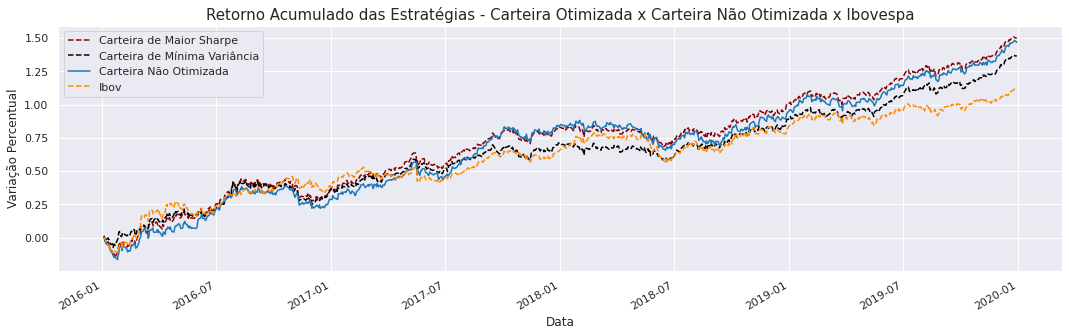

In [134]:
Carteira_Alvos['MaiorSharpe'].cumsum().plot(ls='--',color='darkred',label='Carteira de Maior Sharpe')
Carteira_Alvos['MínimaVariância'].cumsum().plot(ls='--',color='black',label='Carteira de Mínima Variância')
plt.plot(Carteira.sum(axis=1).pct_change().cumsum(),color='tab:blue',label='Carteira Não Otimizada')
plt.plot(Ibov_Norm.pct_change().cumsum(),ls='--',color='darkorange',label='Ibov')
plt.title('Retorno Acumulado das Estratégias - Carteira Otimizada x Carteira Não Otimizada x Ibovespa',fontsize = 15)
plt.xlabel('Data')
plt.ylabel('Variação Percentual')
plt.legend()
plt.show()

## VaR das Carteiras:

In [53]:
def mc_Sim(S,u,T,sigma,N):
  total_sim = np.zeros((256,N))
  p_inicial = S        
  for j in range(N):
    aux = 1
    p = p_inicial 
    preco = [p] #Vetor para acumular os precos ao longo do tempo
    dist = np.random.normal(0,1,255) #Distribuicao normal, 255 valores, com media 0 e desvio p. 1
    for i in dist:
      P = p + p*(u/255 + sigma/np.sqrt(255)*i)
      preco.append(P)                        
      p = P                                 
      aux = aux + 1
    total_sim[:,j] = preco
  return total_sim     

### VaR Carteira Maior Sharpe:

In [85]:
ST = mc_Sim(1000,0.38,252,0.13,2000)

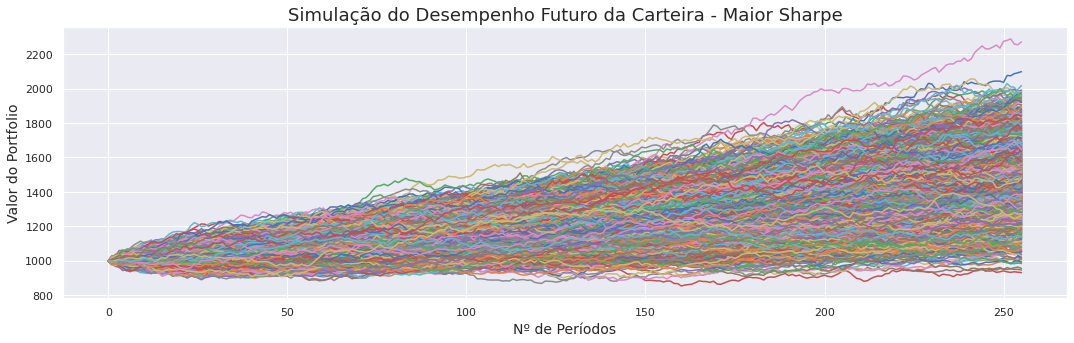

In [68]:
plt.plot(ST)
plt.title('Simulação do Desempenho Futuro da Carteira - Maior Sharpe',fontsize=18)
plt.xlabel('Nº de Períodos',fontsize=14)
plt.ylabel('Valor do Portfolio',fontsize=14)
plt.show()

### Quantis dos Retornos Simulados:

In [63]:
np.round(np.quantile(ST,(0.05,0.95)),4)

array([ 995.3504, 1551.4075])

### Menor Retorno:

In [88]:
np.round(np.min(ST),4)

838.6537

### VaR:

In [86]:
np.round((1-1000/np.quantile(ST,(0.01,0.05,0.95)))*100,4)

array([-3.9062, -0.2812, 35.7777])

### VaR Carteira Mínima Variância:

In [66]:
MT = mc_Sim(10000,0.34,252,0.128,2000)

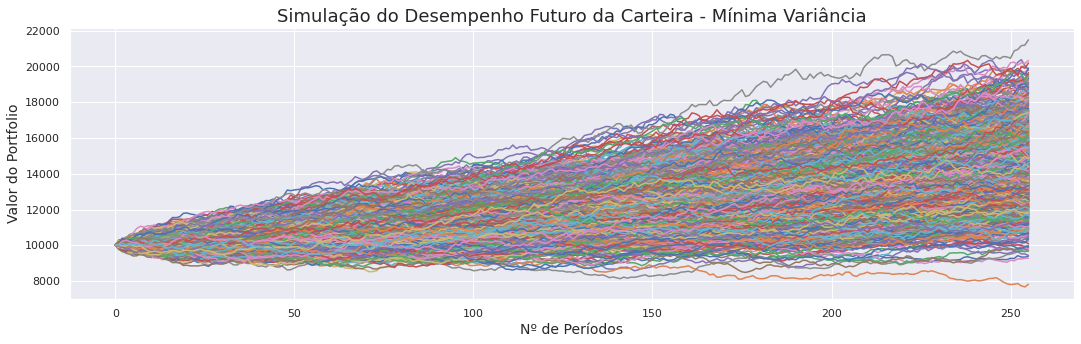

In [69]:
plt.plot(MT)
plt.title('Simulação do Desempenho Futuro da Carteira - Mínima Variância',fontsize=18)
plt.xlabel('Nº de Períodos',fontsize=14)
plt.ylabel('Valor do Portfolio',fontsize=14)
plt.show()

### Percentis dos Retornos Simulados:

In [70]:
np.round(np.quantile(MT,(0.05,0.95)),4)

array([ 9917.799 , 15071.1405])

### Menor Retorno:

In [73]:
np.round(np.min(MT),4)

7671.6304

### VaR:

In [87]:
(1-1000/np.quantile(MT,(0.01,0.05,0.95)))*100

array([89.49332054, 89.91711768, 93.36480208])

In [80]:
np.round((1-1000/np.quantile(MT,(0.01,0.05,0.95)))*100,4)

array([89.4933, 89.9171, 93.3648])